<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1lTXV5g-jajeWgE8AM7VRJ1UA4galvYfS" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

**Antes de empezar, instalamos algunos paquetes en el sistema. Los usaremos más adelante.**

In [ ]:
!pip install -q deap
!pip install -q ACO-Pants
!pip install -q pyswarm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


# **Optimización**

En matemáticas, estadística, economía, ciencias empíricas y ciencia de la computación, la optimización (también, optimización matemática o programación matemática) es la selección del mejor elemento (con respecto a algún criterio) de un conjunto de elementos disponibles.

En el caso más simple, un problema de optimización consiste en maximizar o minimizar una función real eligiendo sistemáticamente valores de entrada (tomados de un conjunto permitido) y computando el valor de la función. La generalización de la teoría de la optimización y técnicas para otras formulaciones comprende un área grande de las matemáticas aplicadas. De forma general, la optimización incluye el descubrimiento de los "mejores valores" de alguna función objetivo dado un dominio definido, incluyendo una variedad de diferentes tipos de funciones objetivo y diferentes tipos de dominios.

[Entrada en la Wikipedia](https://es.wikipedia.org/wiki/Optimizaci%C3%B3n_(matem%C3%A1tica))



<hr>

La **función de Rosenbrock** es una función no convexa utilizada como problema de prueba del rendimiento para algoritmos de optimización que se introdujo por Howard H. Rosenbrock en 1960. Es también conocida como la función del valle o la función del plátano.

El mínimo global está dentro de un valle plano, largo, estrecho y de forma parabólica. Encontrar el valle es trivial. Sin embargo, converger al mínimo global es difícil.

La función es ...

$$f(x, y) = (a-x)^2 + b(y-x^2)^2$$

... teniendo dos parámetros, $a$ y $b$, que usualmente poseen los valores 1 y 100 respectivamente.

La función es tridimensional.

El objetivo de la optimización usando esta función es buscar la pareja $(x,y)$ que minimiza $f(x,y)$.

La mejor solución (para $a$=1 y $b$=100) es (1,1). El mínimo global.


In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

# Estos dos valores son globales.
A=1
B=100

# Crear una malla de valores para x e y
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x, y)

# Definición de la función de Rosenbrock
Z = (A - X)**2 + B * (Y - X**2)**2

# Crear la figura 3D
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

# Configurar la figura
fig.update_layout(scene = dict(
                  xaxis_title='X',
                  yaxis_title='Y',
                  zaxis_title='Z(x,y)'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# Mostrar la figura
fig.show()


Probablemente pienses que la solución es  (1,1) como he dicho antes, pero que en (-1, 1) hay otra, pero no.

Esta función se usa como prueba de algoritmos de optimización porque tiene un mínimo global otros mínimos locales y alguna trampa (en la colina).

Vamos a hacer un corte en $y$=1 para ver como no es un mímino.

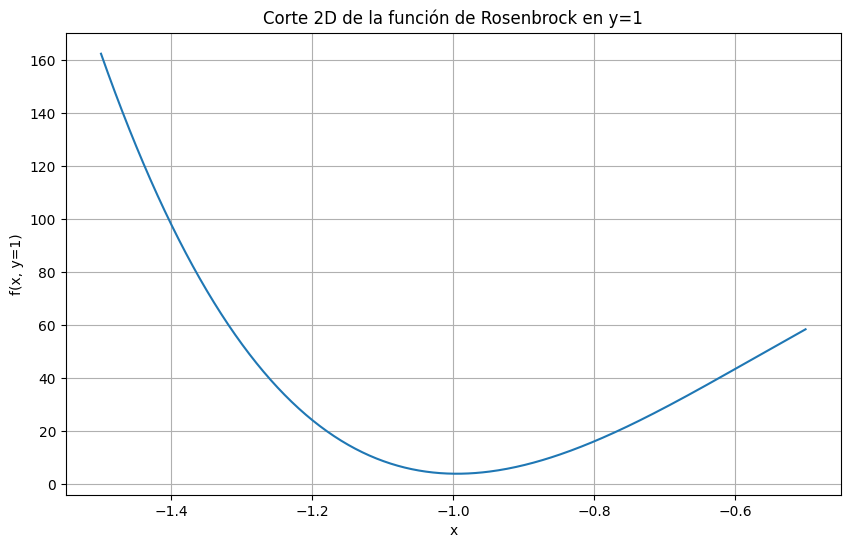

In [2]:
def rosenbrock(x, y=1, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

x = np.linspace(-1.5, -0.5, 400)
y = np.ones_like(x)  # y=1 en todo el rango

z = rosenbrock(x, y)

plt.figure(figsize=(10, 6))
plt.plot(x, z)
plt.title('Corte 2D de la función de Rosenbrock en y=1')
plt.xlabel('x')
plt.ylabel('f(x, y=1)')
plt.grid(True)
plt.show()


Para $x$=1 e $y$=1, $f(x,y)$=0. Es nuestro mínimo global.

Observa como en $x$=-1 e $y$=1, $f(x,y)$ NO es cero.

**NOTA**: *En este caso, el mínimo es cero, pero el objetivo de la optimización es buscar un mínimo global, no los ceros*.

## **Algoritmo genético**

En los años 1970, de la mano de John Henry Holland, surgió una de las líneas más prometedoras de la inteligencia artificial, la de los algoritmos genéticos, (AG). Son llamados así porque se inspiran en la evolución biológica y su base genético-molecular.

Estos algoritmos hacen evolucionar una población de individuos sometiéndola a acciones aleatorias, semejantes a las que actúan en la evolución biológica (mutaciones y recombinaciones genéticas), así como también a una selección. De acuerdo con algún criterio, se decide cuáles son los individuos más adaptados, que sobreviven, y cuáles son los menos aptos, que son descartados.

Los algoritmos genéticos se enmarcan dentro de los algoritmos evolutivos, que incluyen también las estrategias evolutivas, la programación evolutiva y la programación genética.

[Entrada en la wikipedia](https://es.wikipedia.org/wiki/Algoritmo_gen%C3%A9tico)

In [ ]:
from deap import base, creator, tools, algorithms
import random
import numpy as np

# Definir la función objetivo (seguimos con la función de Rosenbrock)
def rosenbrock(individual):
    x = individual[0];
    y = individual[1];
    return ((A - x)**2 + B*(y - x**2)**2,);

# Definir el tipo de optimización (minimización)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Registrar el generador de números aleatorios para las variables x e y
toolbox.register("attr_float", random.uniform, -5, 5)

# Registrar el generador de individuos y la población
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registrar la función objetivo
toolbox.register("evaluate", rosenbrock)

# Registrar el operador de cruzamiento, mutación y selección
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Crear una población inicial de 300 individuos
population = toolbox.population(n=300)

# Parámetros del algoritmo genético
ngen = 40
cxpb = 0.7
mutpb = 0.2

# Utilizar el algoritmo genético simple
algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Obtener el mejor individuo de la población final
best_ind = tools.selBest(population, 1)[0]

print("La mejor solución fue x = {}, y = {}".format(best_ind[0], best_ind[1]))


gen	nevals
0  	300   
1  	241   
2  	217   
3  	228   
4  	232   
5  	229   
6  	215   
7  	231   
8  	197   
9  	233   
10 	220   
11 	238   
12 	220   
13 	226   
14 	225   
15 	228   
16 	234   
17 	238   
18 	219   
19 	228   
20 	221   
21 	223   
22 	230   
23 	230   
24 	235   
25 	222   
26 	229   
27 	224   
28 	227   
29 	220   
30 	235   
31 	227   
32 	223   
33 	244   
34 	235   
35 	224   
36 	229   
37 	227   
38 	215   
39 	255   
40 	229   
La mejor solución fue x = 0.8795924026351241, y = 0.7700111337657365


## **Colonia de hormigas**

En ciencias de la computación y en investigación operativa, el algoritmo de la colonia de hormigas, algoritmo hormiga u optimización por colonia de hormigas (Ant Colony Optimization, ACO) es una técnica probabilística para solucionar problemas computacionales que pueden reducirse a buscar los mejores caminos o rutas en grafos.

Este algoritmo es un miembro de la familia de los algoritmos de colonia de hormigas, dentro de los métodos de inteligencia de enjambres. Inicialmente propuesto por Marco Dorigo en 1992 en su tesis de doctorado, el primer algoritmo surgió como método para buscar el camino óptimo en un grafo, basado en el comportamiento de las hormigas cuando estas están buscando un camino entre la colonia y una fuente de alimentos. La idea original se ha diversificado para resolver una amplia clase de problemas numéricos, y como resultado, han surgido gran cantidad de problemas nuevos, basándose en diversos aspectos del comportamiento de las hormigas.

[Entrada en la Wikipedia](https://es.wikipedia.org/wiki/Algoritmo_de_la_colonia_de_hormigas)


In [ ]:
import pants
import math
import random

def euclidean(a, b):
    return math.sqrt(pow(a[1] - b[1], 2) + pow(a[0] - b[0], 2))

def rosenbrock(point):
    x, y = point
    return (A - x)**2 + B * (y - x**2)**2

nodes = [(random.uniform(-5, 5), random.uniform(-5, 5)) for _ in range(500)]

world = pants.World(nodes, euclidean)
solver = pants.Solver()

solution = solver.solve(world)

best_point = solution.tour[-1]
print("La mejor solución es en el punto:", best_point)
print("El valor de la función objetivo en este punto es:", rosenbrock(best_point))


La mejor solución es en el punto: (3.481960028115923, -4.946602969194052)
El valor de la función objetivo en este punto es: 29146.86451055221


## **Enjambre de partículas**

En informática, la optimización por nube de partículas u optimización por enjambre de partículas (conocida por sus siglas en inglés: PSO, de «particle swarm optimization») hace referencia a una **metaheurística** que evoca el comportamiento de las partículas en la naturaleza.

Los métodos PSO se atribuyen originalmente a los investigadores Kennedy, Eberhart y Shi. En un principio fueron concebidos para elaborar modelos de conductas sociales, como el movimiento descrito por los organismos vivos en una bandada de aves o un banco de peces. Posteriormente el algoritmo se simplificó y se comprobó que era adecuado para problemas de optimización.

PSO permite optimizar un problema a partir de una población de soluciones candidatas, denotadas como "partículas", moviendo éstas por todo el espacio de búsqueda según reglas matemáticas que tienen en cuenta la posición y la velocidad de las partículas. El movimiento de cada partícula se ve influido por su mejor posición local hallada hasta el momento, así como por las mejores posiciones globales encontradas por otras partículas a medida que recorren el espacio de búsqueda. El fundamento teórico de esto es hacer que la nube de partículas converja rápidamente hacia las mejores soluciones.

PSO es una **metaheurística**, ya que asume pocas o ninguna hipótesis sobre el problema a optimizar y puede aplicarse en grandes espacios de soluciones candidatas. **Sin embargo, como toda metaheurística, PSO no garantiza la obtención de una solución óptima en todos los casos.**

[Entrada en la wikipedia](https://es.wikipedia.org/wiki/Optimizaci%C3%B3n_por_enjambre_de_part%C3%ADculas)

In [ ]:
from pyswarm import pso
import numpy as np

# Definir la función objetivo (función de Rosenbrock)
def rosenbrock(x):
    x1, x2 = x
    return (A - x1)**2 + B * (x2 - x1**2)**2

# Límites para x1 y x2
lb = [-5, -5]
ub = [5, 5]

# Ejecutar PSO
xopt, fopt = pso(rosenbrock, lb, ub)

# Resultados
print(f"Posición óptima: {xopt}")
print(f"Valor mínimo de la función objetivo: {fopt}")


Stopping search: Swarm best objective change less than 1e-08
Posición óptima: [1.00011918 1.00023148]
Valor mínimo de la función objetivo: 1.896683144621584e-08


## **Descenso del gradiente**

El descenso del gradiente es un algoritmo de optimización iterativo de primer orden que permite encontrar mínimos locales **en una función diferenciable**. La idea es tomar pasos de manera repetida en dirección contraria al gradiente. Esto se hace ya que esta dirección es la del descenso más empinado. Si se toman pasos con la misma dirección del gradiente, se encontrará el máximo local de la función; a esto se le conoce como el gradiente ascendente.

Este algoritmo es utilizado para entrenar modelos de aprendizaje máquina y redes neuronales.

[Entrada en la Wikipedia](https://es.wikipedia.org/wiki/Descenso_del_gradiente)

In [ ]:
import numpy as np

# Definición de la función de Rosenbrock
def rosenbrock(x, y):
    return (A - x)**2 + B*(y - x**2)**2

# Gradiente de la función de Rosenbrock
def gradient(x, y):
    dx = -2*(A - x) - 4*B*x*(y - x**2)
    dy = 2*B*(y - x**2)
    return np.array([dx, dy])

# Parámetros del algoritmo
learning_rate = 0.001  # Tasa de aprendizaje más pequeña
iterations = 50000     # Mayor número de iteraciones
tolerance = 1e-13      # Tolerancia más pequeña

# Punto de inicio
p_init = np.random.uniform(-2, 2, 2)
p = p_init

# Algoritmo de descenso del gradiente
# Observar que no estamos usando ninguna librería especializada
for i in range(iterations):
    grad = gradient(p[0], p[1]) # x,y
    p_new = p - learning_rate * grad

    if np.sum(abs(p_new - p)) < tolerance:
        print("Convergencia alcanzada.")
        break

    p = p_new

print(f"El mínimo se encuentra en {p}, y el valor de la función en ese punto es {rosenbrock(p[0], p[1])}.")


El mínimo se encuentra en [1. 1.], y el valor de la función en ese punto es 4.1834626501169453e-19.
